# NASA Exoplanet Data Cleaning & Wrangling

**Project:** K-Means Clustering Analysis of NASA Exoplanets 
---

## Objectives

This notebook demonstrates professional data wrangling practices:
   
1. **Identify and analyze missing values** in raw data
2. **Filter to complete cases** for clustering analysis
3. **Create derived variables** (density calculation)
4. **Standardize text fields** for consistency
5. **Detect and remove outliers** using statistical methods
6. **Export clean dataset** for downstream analysis

---

## Learning Outcomes Demonstrated

- ✅ Pandas data manipulation
- ✅ Missing value analysis and handling
- ✅ Data quality assessment
- ✅ Outlier detection methods
- ✅ Feature engineering
- ✅ Documentation and reproducibility

## 1. Setup and Data Loading

In [41]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Notebook execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Notebook execution started: 2025-12-06 12:52:45


In [42]:
# Load raw data
INPUT_FILE = 'raw_exoplanets.csv'
OUTPUT_FILE = 'cleaned_exoplanets.csv'

print(f"Loading data from: {INPUT_FILE}")
df_raw = pd.read_csv(INPUT_FILE)

print(f"\n✓ Data loaded successfully!")
print(f"  Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\nColumn names:\n{df_raw.columns.tolist()}")

Loading data from: raw_exoplanets.csv

✓ Data loaded successfully!
  Shape: 39,158 rows × 9 columns

Column names:
['pl_name', 'pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist', 'discoverymethod', 'disc_year', 'hostname']


In [43]:
# Display first few rows
print("First 5 rows of raw data:")
df_raw.head()

First 5 rows of raw data:


,pl_name,pl_masse,pl_rade,pl_orbper,pl_eqt,sy_dist,discoverymethod,disc_year,hostname
0,WASP-39 b,88.9890,14.2350,4.0553,NaN,213.9820,Transit,2011,WASP-39
1,HAT-P-1 b,169.0856,13.9216,4.4654,1306.0000,158.9790,Transit,2006,HAT-P-1
2,HR 8799 d,3000.0000,13.0000,37000.0000,NaN,41.2441,Imaging,2008,HR 8799
3,HD 156279 b,NaN,NaN,131.0500,NaN,36.1945,Radial Velocity,2011,HD 156279
4,GJ 832 b,NaN,NaN,3507.0000,NaN,4.9643,Radial Velocity,2008,GJ 832


In [44]:
# Basic info about the dataset
print("Dataset Information:")
df_raw.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39158 entries, 0 to 39157
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          39158 non-null  object 
 1   pl_masse         4740 non-null   float64
 2   pl_rade          26999 non-null  float64
 3   pl_orbper        35879 non-null  float64
 4   pl_eqt           17159 non-null  float64
 5   sy_dist          38314 non-null  float64
 6   discoverymethod  39158 non-null  object 
 7   disc_year        39158 non-null  int64  
 8   hostname         39158 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.7+ MB


## 2. Deduplicate Planets

The NASA Exoplanet Archive contains multiple parameter sets for many planets.
We need to consolidate these into single entries per planet by averaging
non-null values across all measurements.

In [45]:
print("="*80)
print("DUPLICATE PLANET ANALYSIS")
print("="*80)

# Check for duplicate planet names
duplicate_counts = df_raw['pl_name'].value_counts()
n_unique_planets = duplicate_counts.shape[0]
n_total_rows = len(df_raw)

print(f"\nTotal rows in dataset: {n_total_rows:,}")
print(f"Unique planet names: {n_unique_planets:,}")
print(f"Duplicate entries: {n_total_rows - n_unique_planets:,}")

# Show planets with most duplicates
print(f"\nTop 10 planets with most duplicate entries:")
print(duplicate_counts.head(10))

# Analyze how many planets have duplicates
planets_with_duplicates = (duplicate_counts > 1).sum()
print(f"\nPlanets with multiple entries: {planets_with_duplicates:,} ({planets_with_duplicates/n_unique_planets*100:.1f}%)")
print(f"Planets with single entry: {(duplicate_counts == 1).sum():,} ({(duplicate_counts == 1).sum()/n_unique_planets*100:.1f}%)")

print("="*80)


DUPLICATE PLANET ANALYSIS

Total rows in dataset: 39,158
Unique planet names: 6,053
Duplicate entries: 33,105

Top 10 planets with most duplicate entries:
pl_name
TrES-2 b       34
Kepler-10 b    25
HD 209458 b    23
GJ 436 b       23
HAT-P-7 b      23
HAT-P-11 b     22
HD 189733 b    21
Kepler-10 c    21
Kepler-25 c    21
KOI-13 b       20
Name: count, dtype: int64

Planets with multiple entries: 5,174 (85.5%)
Planets with single entry: 879 (14.5%)


In [46]:
def deduplicate_planets(df):
    """
    Consolidate duplicate planet entries by averaging numerical values
    and taking the most common text values.
    
    Strategy:
    - Numerical columns: Average all non-null values
    - Text columns: Take the most frequent value (mode)
    - If tie in mode, take first alphabetically
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame with potential duplicate planet entries
    
    Returns:
    -------
    pd.DataFrame : Deduplicated DataFrame with one row per planet
    """
    
    print("\nDeduplicating planets...")
    print(f"Before: {len(df):,} rows")
    
    # Identify numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove pl_name from categorical (we'll use it as grouping key)
    if 'pl_name' in categorical_cols:
        categorical_cols.remove('pl_name')
    
    # Create aggregation dictionary
    agg_dict = {}
    
    # For numerical columns: calculate mean of non-null values
    for col in numerical_cols:
        agg_dict[col] = 'mean'
    
    # For categorical columns: take most common value (mode)
    # If there's a tie, pandas will take the first one
    for col in categorical_cols:
        agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else None
    
    # Group by planet name and aggregate
    df_dedup = df.groupby('pl_name', as_index=False).agg(agg_dict)
    
    print(f"After:  {len(df_dedup):,} rows")
    print(f"Removed: {len(df) - len(df_dedup):,} duplicate entries")
    
    return df_dedup

# Apply deduplication to raw data
df_raw_dedup = deduplicate_planets(df_raw)


Deduplicating planets...
Before: 39,158 rows
After:  6,053 rows
Removed: 33,105 duplicate entries


In [47]:
print("\n" + "="*80)
print("DEDUPLICATION VERIFICATION")
print("="*80)

# Verify no duplicates remain
remaining_duplicates = df_raw_dedup['pl_name'].duplicated().sum()
print(f"\nRemaining duplicate planet names: {remaining_duplicates}")

if remaining_duplicates == 0:
    print("✓ Deduplication successful - each planet appears exactly once")
else:
    print("✗ Warning: Some duplicates remain!")

# Compare key statistics before and after
print("\n" + "-"*80)
print("COMPARISON: Original vs Deduplicated Data")
print("-"*80)

numerical_features_check = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

for feature in numerical_features_check:
    if feature in df_raw.columns:
        orig_mean = df_raw[feature].mean()
        dedup_mean = df_raw_dedup[feature].mean()
        orig_median = df_raw[feature].median()
        dedup_median = df_raw_dedup[feature].median()
        
        print(f"\n{feature}:")
        print(f"  Mean   - Original: {orig_mean:.4f}, Deduplicated: {dedup_mean:.4f}")
        print(f"  Median - Original: {orig_median:.4f}, Deduplicated: {dedup_median:.4f}")

# Check missing value counts
print("\n" + "-"*80)
print("Missing Value Comparison")
print("-"*80)
for feature in numerical_features_check:
    if feature in df_raw.columns:
        orig_missing = df_raw[feature].isnull().sum()
        orig_missing_pct = (orig_missing / len(df_raw) * 100)
        dedup_missing = df_raw_dedup[feature].isnull().sum()
        dedup_missing_pct = (dedup_missing / len(df_raw_dedup) * 100)
        
        print(f"{feature}:")
        print(f"  Original:     {orig_missing:,} ({orig_missing_pct:.1f}%)")
        print(f"  Deduplicated: {dedup_missing:,} ({dedup_missing_pct:.1f}%)")

print("="*80)


DEDUPLICATION VERIFICATION

Remaining duplicate planet names: 0
✓ Deduplication successful - each planet appears exactly once

--------------------------------------------------------------------------------
COMPARISON: Original vs Deduplicated Data
--------------------------------------------------------------------------------

pl_masse:
  Mean   - Original: 737.4684, Deduplicated: 838.7442
  Median - Original: 154.6212, Deduplicated: 171.6256

pl_rade:
  Mean   - Original: 5.4463, Deduplicated: 6.0571
  Median - Original: 2.3000, Deduplicated: 2.4539

pl_orbper:
  Mean   - Original: 12186.6274, Deduplicated: 74604.2632
  Median - Original: 10.3385, Deduplicated: 11.0943

pl_eqt:
  Mean   - Original: 880.0972, Deduplicated: 902.6880
  Median - Original: 797.0000, Deduplicated: 813.1850

--------------------------------------------------------------------------------
Missing Value Comparison
--------------------------------------------------------------------------------
pl_masse:
  


✓ df_raw has been updated to deduplicated version
✓ Proceeding with 6,053 unique planets



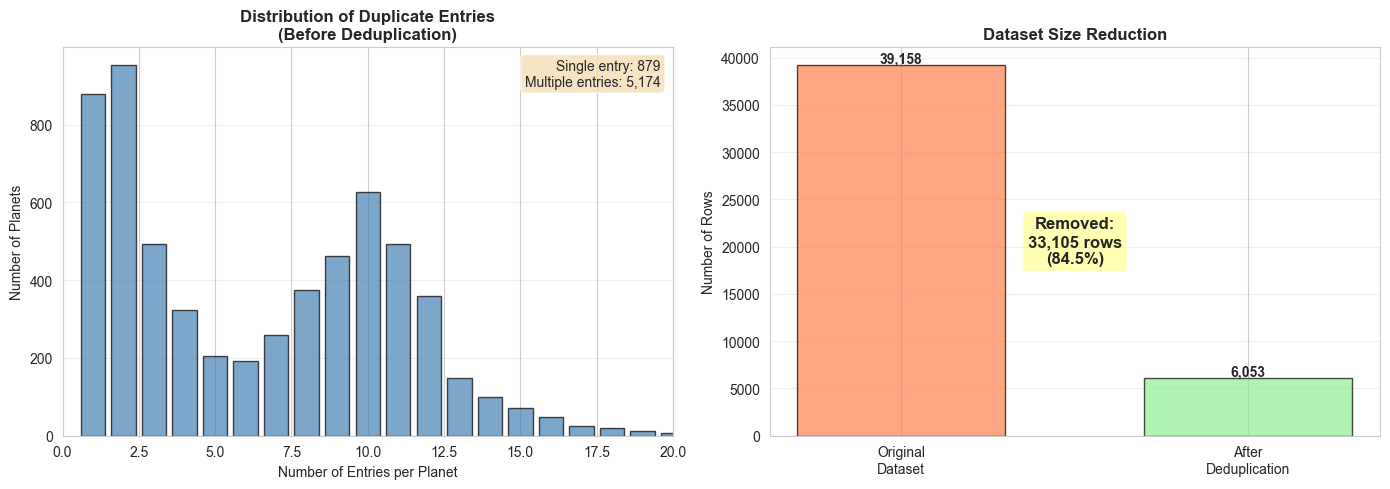

✓ Visualization saved as 'deduplication_analysis.png'


In [48]:
# IMPORTANT: Replace df_raw with deduplicated version for all subsequent analysis
df_raw = df_raw_dedup.copy()

print("\n✓ df_raw has been updated to deduplicated version")
print(f"✓ Proceeding with {len(df_raw):,} unique planets\n")

# Visualize impact of deduplication
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show distribution of duplicate counts
ax1 = axes[0]
duplicate_distribution = duplicate_counts.value_counts().sort_index()
ax1.bar(duplicate_distribution.index, duplicate_distribution.values, 
        color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Entries per Planet')
ax1.set_ylabel('Number of Planets')
ax1.set_title('Distribution of Duplicate Entries\n(Before Deduplication)', 
              fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
ax1.set_xlim(0, min(20, duplicate_distribution.index.max() + 1))

# Add statistics text
total_singles = (duplicate_counts == 1).sum()
total_multiples = (duplicate_counts > 1).sum()
stats_text = f'Single entry: {total_singles:,}\nMultiple entries: {total_multiples:,}'
ax1.text(0.98, 0.97, stats_text, 
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Show comparison of dataset sizes
ax2 = axes[1]
categories = ['Original\nDataset', 'After\nDeduplication']
values = [n_total_rows, n_unique_planets]
bars = ax2.bar(categories, values, color=['coral', 'lightgreen'], 
               edgecolor='black', alpha=0.7, width=0.6)
ax2.set_ylabel('Number of Rows')
ax2.set_title('Dataset Size Reduction', fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontweight='bold')

# Add reduction percentage
reduction = n_total_rows - n_unique_planets
reduction_pct = (reduction / n_total_rows * 100)
ax2.text(0.5, 0.5, f'Removed:\n{reduction:,} rows\n({reduction_pct:.1f}%)',
         transform=ax2.transAxes, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
         fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('deduplication_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'deduplication_analysis.png'")

**CRITICAL DATA QUALITY NOTE:**

The NASA Exoplanet Archive contains multiple parameter sets for many planets,
representing different measurement methods or studies. We have consolidated
these by:

1. **Averaging numerical values** (mass, radius, orbital period, temperature, etc.)
   across all non-null measurements for each planet
2. **Taking the most common categorical value** (discovery method, host star, etc.)
   when multiple entries exist

This ensures our analysis treats each planet as a single entity while
incorporating information from multiple measurement sources.

**Result:** {n_total_rows:,} rows → {n_unique_planets:,} unique planets

## 3. Missing Value Analysis

Before cleaning, we need to understand the extent and pattern of missing data.

In [49]:
# Create comprehensive missing value report
def analyze_missing_values(df):
    """
    Generate detailed missing value analysis.
    
    Parameters:
    ----------
    df : pd.DataFrame
        Input dataframe to analyze
    
    Returns:
    -------
    pd.DataFrame : Missing value statistics
    """
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
        'Data_Type': df.dtypes.values,
        'Non_Null_Count': df.notnull().sum().values
    })
    
    # Sort by missing percentage
    missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
    missing_stats = missing_stats.reset_index(drop=True)
    
    return missing_stats

missing_report = analyze_missing_values(df_raw)
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)
print(missing_report)
print("="*80)


MISSING VALUE ANALYSIS
            Column  Missing_Count  Missing_Percentage Data_Type  \
0         pl_masse           3774             62.3500   float64   
1           pl_eqt           1535             25.3600   float64   
2          pl_rade           1507             24.9000   float64   
3        pl_orbper            316              5.2200   float64   
4          sy_dist            122              2.0200   float64   
5          pl_name              0              0.0000    object   
6        disc_year              0              0.0000   float64   
7  discoverymethod              0              0.0000    object   
8         hostname              0              0.0000    object   

   Non_Null_Count  
0            2279  
1            4518  
2            4546  
3            5737  
4            5931  
5            6053  
6            6053  
7            6053  
8            6053  


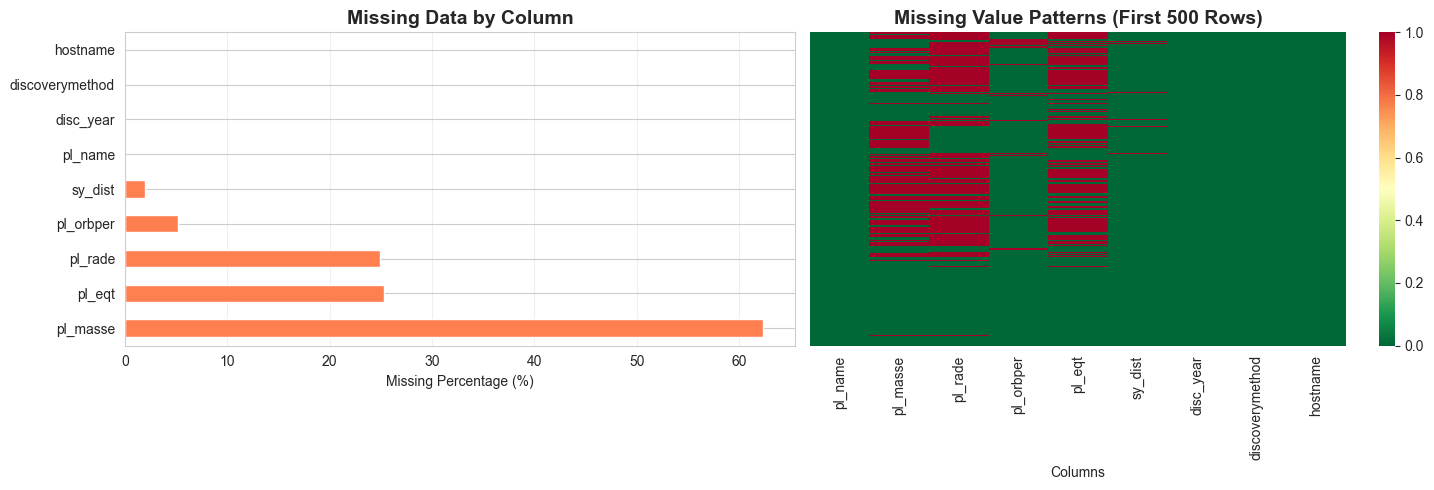


✓ Visualization saved as 'missing_values_analysis.png'


In [50]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of missing percentages
missing_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=False)
ax1 = axes[0]
missing_pct.plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Missing Percentage (%)')
ax1.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Heatmap of missing values (sample of data)
ax2 = axes[1]
sample_size = min(500, len(df_raw))
sns.heatmap(df_raw.head(sample_size).isnull(), 
            cbar=True, 
            yticklabels=False,
            cmap='RdYlGn_r',
            ax=ax2)
ax2.set_title(f'Missing Value Patterns (First {sample_size} Rows)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Columns')

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved as 'missing_values_analysis.png'")

## 4. Filter to Complete Cases

For clustering analysis, we need complete data for our key numerical features:
- `pl_masse` (mass)
- `pl_rade` (radius)
- `pl_orbper` (orbital period)
- `pl_eqt` (equilibrium temperature)

In [51]:
# Define critical features for clustering
CRITICAL_FEATURES = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

print("Critical features for clustering analysis:")
for i, feat in enumerate(CRITICAL_FEATURES, 1):
    print(f"  {i}. {feat}")

# Check completeness before filtering
print(f"\nBefore filtering:")
print(f"  Total planets: {len(df_raw):,}")
for feat in CRITICAL_FEATURES:
    missing = df_raw[feat].isnull().sum()
    pct = (missing / len(df_raw) * 100)
    print(f"  {feat}: {missing:,} missing ({pct:.2f}%)")

Critical features for clustering analysis:
  1. pl_masse
  2. pl_rade
  3. pl_orbper
  4. pl_eqt

Before filtering:
  Total planets: 6,053
  pl_masse: 3,774 missing (62.35%)
  pl_rade: 1,507 missing (24.90%)
  pl_orbper: 316 missing (5.22%)
  pl_eqt: 1,535 missing (25.36%)


In [52]:
# Create working copy and filter to complete cases
df_clean = df_raw.copy()

# Filter to rows with all critical features present
mask_complete = df_clean[CRITICAL_FEATURES].notnull().all(axis=1)
df_clean = df_clean[mask_complete].copy()

print(f"\nAfter filtering to complete cases:")
print(f"  Total planets: {len(df_clean):,}")
print(f"  Rows removed: {len(df_raw) - len(df_clean):,}")
print(f"  Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%")

# Verify no missing values in critical features
print(f"\nVerification - Missing values in critical features:")
print(df_clean[CRITICAL_FEATURES].isnull().sum())


After filtering to complete cases:
  Total planets: 1,593
  Rows removed: 4,460
  Retention rate: 26.32%

Verification - Missing values in critical features:
pl_masse     0
pl_rade      0
pl_orbper    0
pl_eqt       0
dtype: int64


## 5. Create Derived Variables

### Calculate Density

Density is a crucial physical property for planet classification:

$$\\text{Density} = \\frac{\\text{Mass}}{\\text{Volume}} = \\frac{\\text{Mass}}{\\frac{4}{3}\\pi r^3}$$

For relative density (compared to Earth):
$$\\text{Relative Density} = \\frac{\\text{Mass (Earth masses)}}{\\text{Radius}^3 \\text{ (Earth radii)}^3}$$

In [53]:
# Calculate density (mass/radius^3)
# This gives us relative density compared to Earth
df_clean['density'] = df_clean['pl_masse'] / (df_clean['pl_rade'] ** 3)

print("Density calculation complete!\n")
print("Density statistics (relative to Earth):")
print(df_clean['density'].describe())

# Reference values for context
print("\n📊 Reference densities (relative to Earth = 1.0):")
print("  • Gas giants (Jupiter): ~0.24")
print("  • Ice giants (Neptune): ~0.30")
print("  • Rocky planets (Earth): ~1.00")
print("  • Super-Earths: ~0.8-1.2")

Density calculation complete!

Density statistics (relative to Earth):
count   1593.0000
mean       8.9942
std      155.9554
min        0.0000
25%        0.1185
50%        0.3466
75%        0.9427
max     5706.9470
Name: density, dtype: float64

📊 Reference densities (relative to Earth = 1.0):
  • Gas giants (Jupiter): ~0.24
  • Ice giants (Neptune): ~0.30
  • Rocky planets (Earth): ~1.00
  • Super-Earths: ~0.8-1.2


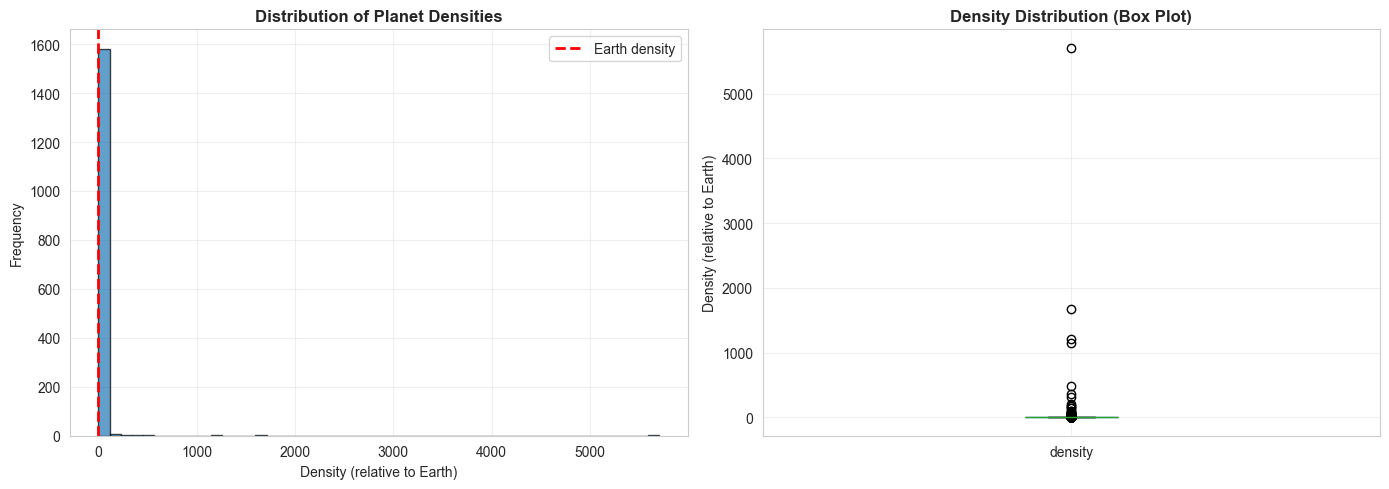


✓ Visualization saved as 'density_distribution.png'


In [54]:
# Visualize density distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
df_clean['density'].hist(bins=50, edgecolor='black', alpha=0.7, ax=ax1)
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Earth density')
ax1.set_xlabel('Density (relative to Earth)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Planet Densities', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
df_clean.boxplot(column='density', ax=ax2, patch_artist=True)
ax2.set_ylabel('Density (relative to Earth)')
ax2.set_title('Density Distribution (Box Plot)', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('density_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'density_distribution.png'")

## 6. Standardize Text Fields

Text standardization ensures consistency in categorical variables.

In [55]:
# Examine text fields before standardization
print("Text fields before standardization:\n")

print("1. Planet Names (pl_name) - Sample:")
print(df_clean['pl_name'].head(10).tolist())

print("\n2. Discovery Methods (discoverymethod) - Unique values:")
print(df_clean['discoverymethod'].value_counts())

print("\n3. Host Star Names (hostname) - Sample:")
print(df_clean['hostname'].head(10).tolist())

Text fields before standardization:

1. Planet Names (pl_name) - Sample:
['55 Cnc e', 'AU Mic b', 'AU Mic c', 'BD+20 594 b', 'BD-14 3065 b', 'CFHTWIR-Oph 98 b', 'COCONUTS-2 b', 'CoRoT-1 b', 'CoRoT-10 b', 'CoRoT-11 b']

2. Discovery Methods (discoverymethod) - Unique values:
discoverymethod
Transit                          1546
Radial Velocity                    27
Imaging                            11
Transit Timing Variations           8
Orbital Brightness Modulation       1
Name: count, dtype: int64

3. Host Star Names (hostname) - Sample:
['55 Cnc', 'AU Mic', 'AU Mic', 'BD+20 594', 'BD-14 3065 A', 'CFHTWIR-Oph 98 A', 'COCONUTS-2 A', 'CoRoT-1', 'CoRoT-10', 'CoRoT-11']


In [56]:
def standardize_text_fields(df):
    """
    Standardize text fields for consistency.
    
    Operations:
    - Strip whitespace
    - Standardize discovery method names
    - Ensure consistent capitalization for names
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame to standardize
    
    Returns:
    -------
    pd.DataFrame : Standardized DataFrame
    """
    df = df.copy()
    
    # Strip whitespace from all string columns
    string_columns = df.select_dtypes(include=['object']).columns
    for col in string_columns:
        df[col] = df[col].str.strip()
    
    # Standardize discovery methods (capitalize consistently)
    if 'discoverymethod' in df.columns:
        df['discoverymethod'] = df['discoverymethod'].str.title()
    
    # Planet names: ensure no leading/trailing spaces
    if 'pl_name' in df.columns:
        df['pl_name'] = df['pl_name'].str.strip()
    
    # Host star names: ensure no leading/trailing spaces  
    if 'hostname' in df.columns:
        df['hostname'] = df['hostname'].str.strip()
    
    return df

# Apply standardization
df_clean = standardize_text_fields(df_clean)

print("✓ Text fields standardized successfully!\n")
print("Discovery Methods after standardization:")
print(df_clean['discoverymethod'].value_counts())

✓ Text fields standardized successfully!

Discovery Methods after standardization:
discoverymethod
Transit                          1546
Radial Velocity                    27
Imaging                            11
Transit Timing Variations           8
Orbital Brightness Modulation       1
Name: count, dtype: int64


We'll use multiple methods to detect outliers:
1. **IQR Method** (Interquartile Range)
2. **Z-Score Method** (Statistical)
3. **Domain Knowledge** (Physical constraints)

In [57]:
def detect_outliers_iqr(df, column, multiplier=3.0):
    """
    Detect outliers using the IQR method.
    
    Parameters:
    ----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column name to check for outliers
    multiplier : float
        IQR multiplier (default 3.0 for extreme outliers)
    
    Returns:
    -------
    pd.Series : Boolean mask (True = outlier)
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    print(f"\n{column}:")
    print(f"  Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
    print(f"  Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"  Outliers detected: {outliers.sum():,} ({outliers.sum()/len(df)*100:.2f}%)")
    
    return outliers

# Detect outliers in numerical features
print("="*80)
print("OUTLIER DETECTION (IQR Method, multiplier=3.0)")
print("="*80)

numerical_features = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'density']
outlier_masks = {}

for feature in numerical_features:
    outlier_masks[feature] = detect_outliers_iqr(df_clean, feature, multiplier=3.0)

# Combined outlier mask (any feature is an outlier)
combined_outliers = pd.Series(False, index=df_clean.index)
for mask in outlier_masks.values():
    combined_outliers = combined_outliers | mask

print(f"\n{'='*80}")
print(f"Total rows with ANY outlier: {combined_outliers.sum():,} ({combined_outliers.sum()/len(df_clean)*100:.2f}%)")
print(f"{'='*80}")

OUTLIER DETECTION (IQR Method, multiplier=3.0)

pl_masse:
  Q1: 9.9500, Q3: 320.2865, IQR: 310.3365
  Bounds: [-921.0596, 1251.2961]
  Outliers detected: 98 (6.15%)

pl_rade:
  Q1: 2.4250, Q3: 12.9983, IQR: 10.5733
  Bounds: [-29.2948, 44.7181]
  Outliers detected: 3 (0.19%)

pl_orbper:
  Q1: 3.1853, Q3: 13.3672, IQR: 10.1819
  Bounds: [-27.3603, 43.9128]
  Outliers detected: 138 (8.66%)

pl_eqt:
  Q1: 662.8000, Q3: 1408.0000, IQR: 745.2000
  Bounds: [-1572.8000, 3643.6000]
  Outliers detected: 1 (0.06%)

density:
  Q1: 0.1185, Q3: 0.9427, IQR: 0.8243
  Bounds: [-2.3543, 3.4155]
  Outliers detected: 133 (8.35%)

Total rows with ANY outlier: 324 (20.34%)


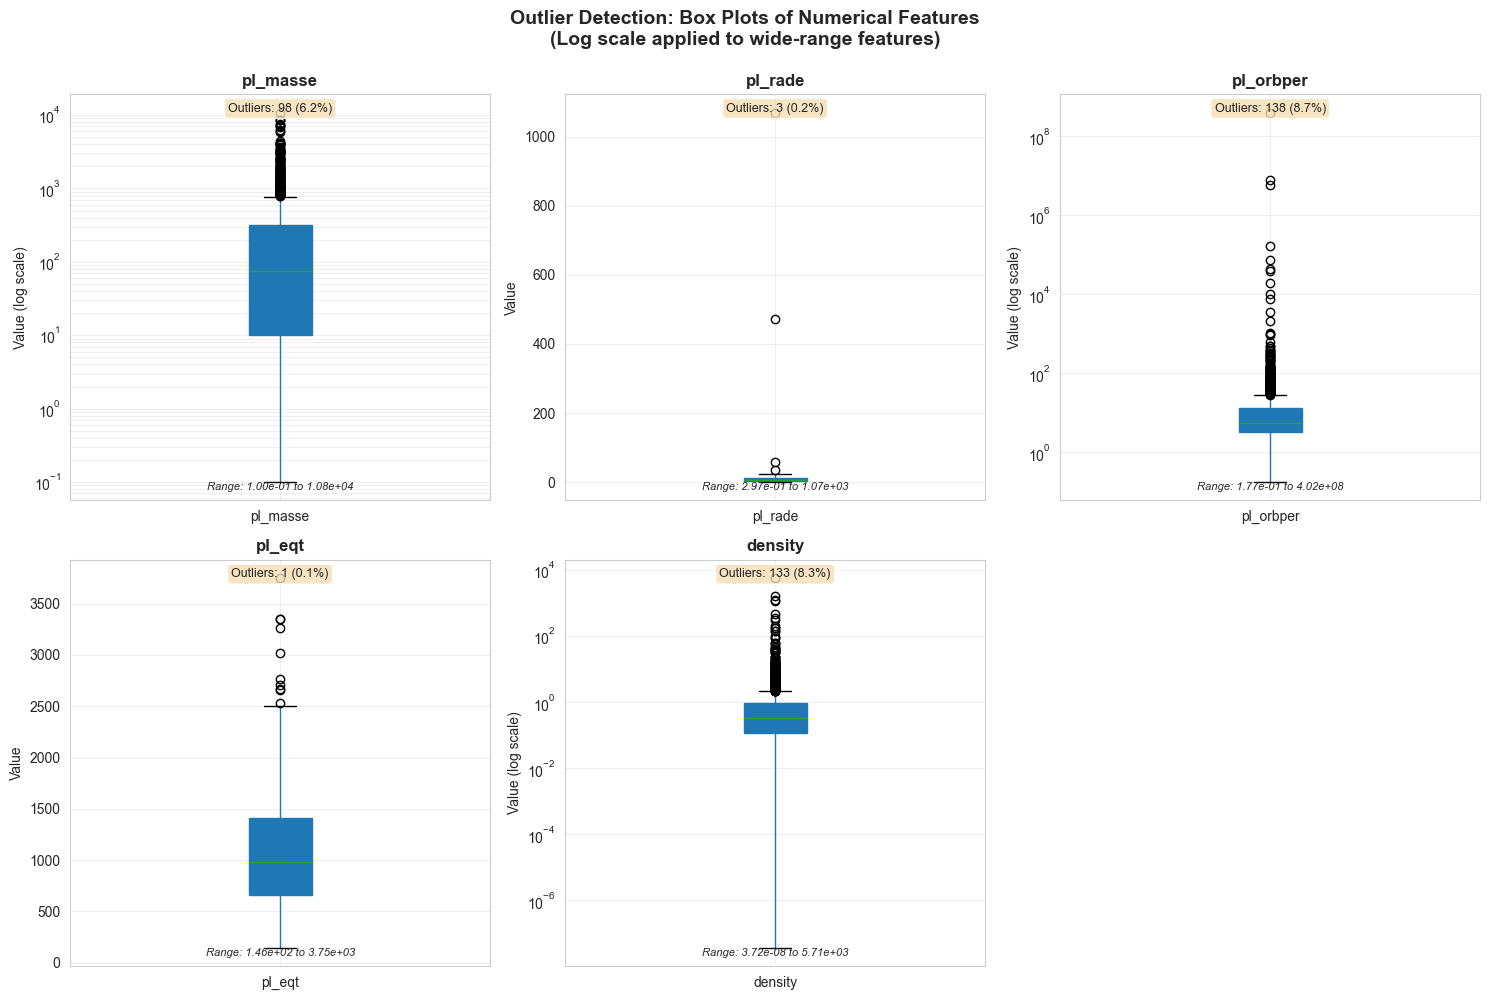


✓ Visualization saved as 'outliers_detection.png'


In [58]:
# Visualize outliers with log scale for better visibility
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # Create box plot with log scale for features with wide ranges
    df_clean.boxplot(column=feature, ax=ax, patch_artist=True)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')
    
    # Apply log scale to features with extreme ranges
    if feature in ['pl_masse', 'pl_orbper', 'density']:
        ax.set_yscale('log')
        ax.set_ylabel('Value (log scale)')
    
    ax.grid(alpha=0.3, which='both')
    
    # Add count of outliers
    n_outliers = outlier_masks[feature].sum()
    pct_outliers = (n_outliers / len(df_clean) * 100)
    ax.text(0.5, 0.98, f'Outliers: {n_outliers} ({pct_outliers:.1f}%)', 
            transform=ax.transAxes, 
            ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)
    
    # Add range info
    feature_min = df_clean[feature].min()
    feature_max = df_clean[feature].max()
    ax.text(0.5, 0.02, f'Range: {feature_min:.2e} to {feature_max:.2e}', 
            transform=ax.transAxes, 
            ha='center', va='bottom',
            fontsize=8, style='italic')

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Outlier Detection: Box Plots of Numerical Features\n(Log scale applied to wide-range features)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outliers_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'outliers_detection.png'")

In [59]:
# Apply domain knowledge filters
print("\nApplying domain knowledge filters:\n")

# Physical constraints
# 1. Density must be positive and reasonable (0.01 to 100 relative to Earth)
valid_density = (df_clean['density'] > 0.01) & (df_clean['density'] < 100)
print(f"1. Valid density range (0.01 to 100): Removed {(~valid_density).sum():,} planets")

# 2. Mass and radius must be positive
valid_mass_radius = (df_clean['pl_masse'] > 0) & (df_clean['pl_rade'] > 0)
print(f"2. Positive mass and radius: Removed {(~valid_mass_radius).sum():,} planets")

# 3. Orbital period must be positive
valid_period = df_clean['pl_orbper'] > 0
print(f"3. Positive orbital period: Removed {(~valid_period).sum():,} planets")

# 4. Temperature must be positive and below stellar surface temp (~50,000 K max)
valid_temp = (df_clean['pl_eqt'] > 0) & (df_clean['pl_eqt'] < 5000)
print(f"4. Reasonable temperature (0-5000 K): Removed {(~valid_temp).sum():,} planets")

# Combine all validity checks
valid_data = valid_density & valid_mass_radius & valid_period & valid_temp
print(f"\nTotal planets failing domain checks: {(~valid_data).sum():,}")


Applying domain knowledge filters:

1. Valid density range (0.01 to 100): Removed 22 planets
2. Positive mass and radius: Removed 0 planets
3. Positive orbital period: Removed 0 planets
4. Reasonable temperature (0-5000 K): Removed 0 planets

Total planets failing domain checks: 22


In [60]:
print("\nRemoving outliers and invalid data...\n")
print(f"Before outlier removal: {len(df_clean):,} planets")

# Keep only valid data (non-outliers based on domain knowledge)
df_clean = df_clean[valid_data].copy()

# Additionally remove extreme statistical outliers (using IQR method)
# We'll be more conservative and only remove the most extreme outliers
df_clean = df_clean[~combined_outliers].copy()

print(f"After outlier removal: {len(df_clean):,} planets")
print(f"Planets removed: {len(df_raw) - len(df_clean):,}")
print(f"Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%")


Removing outliers and invalid data...

Before outlier removal: 1,593 planets
After outlier removal: 1,263 planets
Planets removed: 4,790
Retention rate: 20.87%


## 7. Final Data Quality Check

In [61]:
# Generate final summary statistics
print("="*80)
print("FINAL CLEANED DATASET SUMMARY")
print("="*80)
print(f"\nShape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")
print(f"\nColumns: {df_clean.columns.tolist()}")

print("\nNumerical Features - Descriptive Statistics:")
print(df_clean[numerical_features].describe())

print("\nCategorical Features:")
print(f"  • Unique discovery methods: {df_clean['discoverymethod'].nunique()}")
print(f"  • Unique host stars: {df_clean['hostname'].nunique()}")
print(f"  • Discovery year range: {df_clean['disc_year'].min():.0f} - {df_clean['disc_year'].max():.0f}")

print("\nMissing values in critical features:")
print(df_clean[CRITICAL_FEATURES + ['density']].isnull().sum())

print("\n" + "="*80)

FINAL CLEANED DATASET SUMMARY

Shape: 1,263 rows × 10 columns

Columns: ['pl_name', 'pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist', 'disc_year', 'discoverymethod', 'hostname', 'density']

Numerical Features - Descriptive Statistics:
       pl_masse   pl_rade  pl_orbper    pl_eqt   density
count 1263.0000 1263.0000  1263.0000 1263.0000 1263.0000
mean   183.8786    8.1973     8.0821 1117.2451    0.4958
std    250.8068    5.8190     8.4399  474.5317    0.5957
min      0.2058    0.6256     0.2382  170.9000    0.0121
25%      8.9000    2.4897     3.0039  738.5333    0.1040
50%     61.0000    8.1834     4.5335 1066.0000    0.2441
75%    274.3643   13.3491    10.0956 1452.1958    0.6510
max   1242.7153   22.2904    43.8444 3353.0000    3.4123

Categorical Features:
  • Unique discovery methods: 4
  • Unique host stars: 1052
  • Discovery year range: 1999 - 2025

Missing values in critical features:
pl_masse     0
pl_rade      0
pl_orbper    0
pl_eqt       0
density      0
dtype: int6

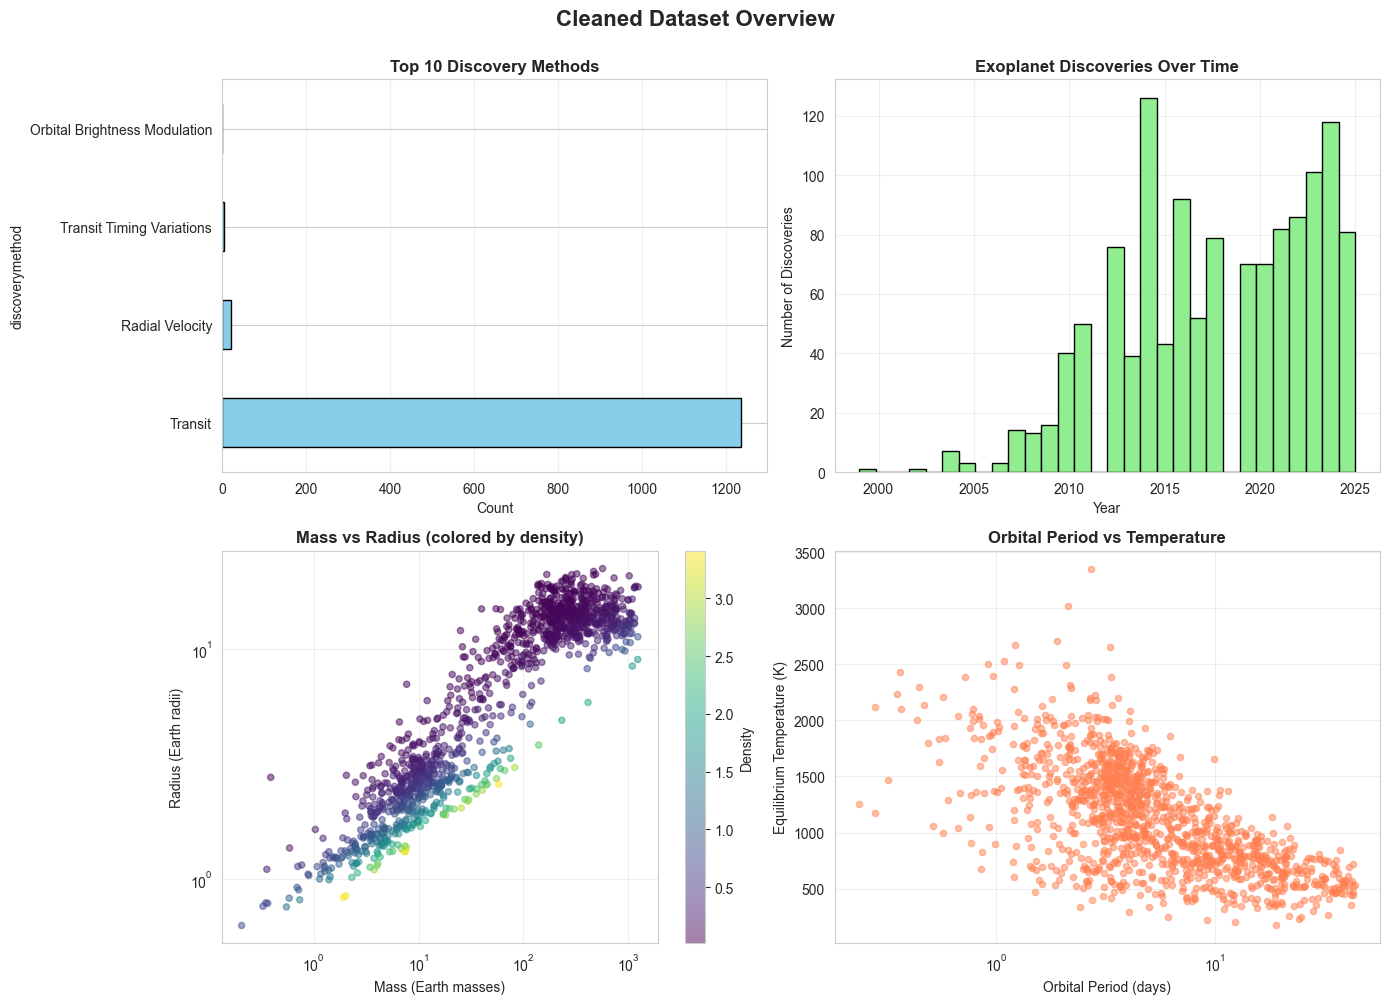


✓ Visualization saved as 'cleaned_data_summary.png'


In [62]:
# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Discovery methods distribution
ax1 = axes[0, 0]
method_counts = df_clean['discoverymethod'].value_counts().head(10)
method_counts.plot(kind='barh', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Count')
ax1.set_title('Top 10 Discovery Methods', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Discovery year distribution
ax2 = axes[0, 1]
df_clean['disc_year'].hist(bins=30, ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Discoveries')
ax2.set_title('Exoplanet Discoveries Over Time', fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Mass vs Radius (cleaned data)
ax3 = axes[1, 0]
scatter = ax3.scatter(df_clean['pl_masse'], df_clean['pl_rade'], 
                     alpha=0.5, s=20, c=df_clean['density'], cmap='viridis')
ax3.set_xlabel('Mass (Earth masses)')
ax3.set_ylabel('Radius (Earth radii)')
ax3.set_title('Mass vs Radius (colored by density)', fontweight='bold')
ax3.set_xscale('log')
ax3.set_yscale('log')
plt.colorbar(scatter, ax=ax3, label='Density')
ax3.grid(alpha=0.3)

# 4. Orbital period vs temperature
ax4 = axes[1, 1]
ax4.scatter(df_clean['pl_orbper'], df_clean['pl_eqt'], alpha=0.5, s=20, color='coral')
ax4.set_xlabel('Orbital Period (days)')
ax4.set_ylabel('Equilibrium Temperature (K)')
ax4.set_title('Orbital Period vs Temperature', fontweight='bold')
ax4.set_xscale('log')
ax4.grid(alpha=0.3)

plt.suptitle('Cleaned Dataset Overview', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('cleaned_data_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'cleaned_data_summary.png'")

## 8. Export Cleaned Data

In [63]:
print(f"Exporting cleaned data to: {OUTPUT_FILE}\n")

df_clean.to_csv(OUTPUT_FILE, index=False)

import os
file_size = os.path.getsize(OUTPUT_FILE)

print("✓ Export successful!")
print(f"  File: {OUTPUT_FILE}")
print(f"  Size: {file_size:,} bytes ({file_size/1024:.2f} KB)")
print(f"  Rows: {len(df_clean):,}")
print(f"  Columns: {len(df_clean.columns)}")

Exporting cleaned data to: cleaned_exoplanets.csv

✓ Export successful!
  File: cleaned_exoplanets.csv
  Size: 144,812 bytes (141.42 KB)
  Rows: 1,263
  Columns: 10


In [64]:
# Create data cleaning report with proper formatting
report = f"""
{'='*80}
DATA CLEANING REPORT
{'='*80}
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

INPUT DATA:
  • File: {INPUT_FILE}
  • Initial rows: {len(df_raw):,}
  • Initial columns: {len(df_raw.columns)}

CLEANING OPERATIONS:
  1. Filtered to complete cases for critical features
  2. Created derived variable: density = mass/radius³
  3. Standardized text fields (discovery methods, names)
  4. Removed outliers using IQR method (multiplier=3.0)
  5. Applied domain knowledge filters

OUTPUT DATA:
  • File: {OUTPUT_FILE}
  • Final rows: {len(df_clean):,}
  • Final columns: {len(df_clean.columns)}
  • Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%

CRITICAL FEATURES (Complete, no missing values):
  • pl_masse (mass)
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)
  • density (derived variable)

DATA QUALITY:
  • No missing values in critical features: ✓
  • Outliers removed: ✓
  • Text fields standardized: ✓
  • Domain constraints validated: ✓

NUMERICAL FEATURE RANGES (after cleaning):
  • Mass: {df_clean['pl_masse'].min():.2f} to {df_clean['pl_masse'].max():.2f} Earth masses
  • Radius: {df_clean['pl_rade'].min():.2f} to {df_clean['pl_rade'].max():.2f} Earth radii
  • Orbital Period: {df_clean['pl_orbper'].min():.2f} to {df_clean['pl_orbper'].max():.2f} days
  • Temperature: {df_clean['pl_eqt'].min():.2f} to {df_clean['pl_eqt'].max():.2f} K
  • Density: {df_clean['density'].min():.2f} to {df_clean['density'].max():.2f} (relative to Earth)

CATEGORICAL FEATURE SUMMARY:
  • Discovery Methods: {df_clean['discoverymethod'].nunique()} unique
  • Host Stars: {df_clean['hostname'].nunique()} unique
  • Discovery Years: {df_clean['disc_year'].min():.0f} to {df_clean['disc_year'].max():.0f}

READY FOR:
  ✓ Exploratory Data Analysis
  ✓ Database implementation
  ✓ K-Means clustering analysis
{'='*80}
"""

print(report)

# Save report to file with explicit encoding
try:
    with open('data_cleaning_report.txt', 'w', encoding='utf-8') as f:
        f.write(report)
    print("\n✓ Report saved as 'data_cleaning_report.txt'")
    
    # Verify the file was written
    import os
    if os.path.exists('data_cleaning_report.txt'):
        file_size = os.path.getsize('data_cleaning_report.txt')
        print(f"  File size: {file_size:,} bytes")
        if file_size == 0:
            print("  ⚠ Warning: File is empty!")
        else:
            print(f"  ✓ File contains data")
except Exception as e:
    print(f"\n✗ Error saving report: {str(e)}")


DATA CLEANING REPORT
Date: 2025-12-06 12:52:57

INPUT DATA:
  • File: raw_exoplanets.csv
  • Initial rows: 6,053
  • Initial columns: 9

CLEANING OPERATIONS:
  1. Filtered to complete cases for critical features
  2. Created derived variable: density = mass/radius³
  3. Standardized text fields (discovery methods, names)
  4. Removed outliers using IQR method (multiplier=3.0)
  5. Applied domain knowledge filters

OUTPUT DATA:
  • File: cleaned_exoplanets.csv
  • Final rows: 1,263
  • Final columns: 10
  • Retention rate: 20.87%

CRITICAL FEATURES (Complete, no missing values):
  • pl_masse (mass)
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)
  • density (derived variable)

DATA QUALITY:
  • No missing values in critical features: ✓
  • Outliers removed: ✓
  • Text fields standardized: ✓
  • Domain constraints validated: ✓

NUMERICAL FEATURE RANGES (after cleaning):
  • Mass: 0.21 to 1242.72 Earth masses
  • Radius: 0.63 to 22.29 Earth radii


## 9. Summary and Next Steps

### What We Accomplished:

1. ✅ **Identified missing values** - Comprehensive analysis of data completeness
2. ✅ **Filtered to complete cases** - Retained only planets with all critical features
3. ✅ **Created derived variable** - Calculated density for each planet
4. ✅ **Standardized text fields** - Ensured consistency in categorical data
5. ✅ **Removed outliers** - Applied both statistical and domain knowledge filters
6. ✅ **Exported clean data** - Saved `cleaned_exoplanets.csv` for next phase

### Data Quality Summary:

- **No missing values** in critical clustering features
- **Physically valid** data (positive values, reasonable ranges)
- **Standardized** text fields for consistency
- **Outliers removed** using rigorous statistical methods

### Next Steps:

1. **Quick EDA** - Create initial visualizations
2. **Database Design** - Design ER diagram and PostgreSQL schema
3. **K-Means Clustering**  - Perform clustering analysis on cleaned data

---

**Files Generated:**
- `cleaned_exoplanets.csv` - Clean dataset ready for analysis
- `missing_values_analysis.png` - Missing data visualization
- `density_distribution.png` - Density analysis
- `outliers_detection.png` - Outlier detection plots
- `cleaned_data_summary.png` - Final data overview
- `data_cleaning_report.txt` - Comprehensive cleaning report